# Localization 4

This is my implementation of the Localization part 4 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. In this section, things are made a little harder for the model by having it detect Pokemon that are randomly flipped along the vertical axis.

Using a topless, pre-trained VGG16 network as a feature extractor we build a small dense layer with four outputs. The outputs represent the column, row, width and height of the Pokemon image.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-4.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-4.ipynb)

In [17]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

IMAGE_DIM = 200

I started with the final code from [Localization 3](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-3.ipynb) and then made the necessary modifications from there.

The Image class in the PIL library that we're using to load and resize the Pokemon also has a transpose function. This function can be used for flipping in the X and Y axes and for image rotation.

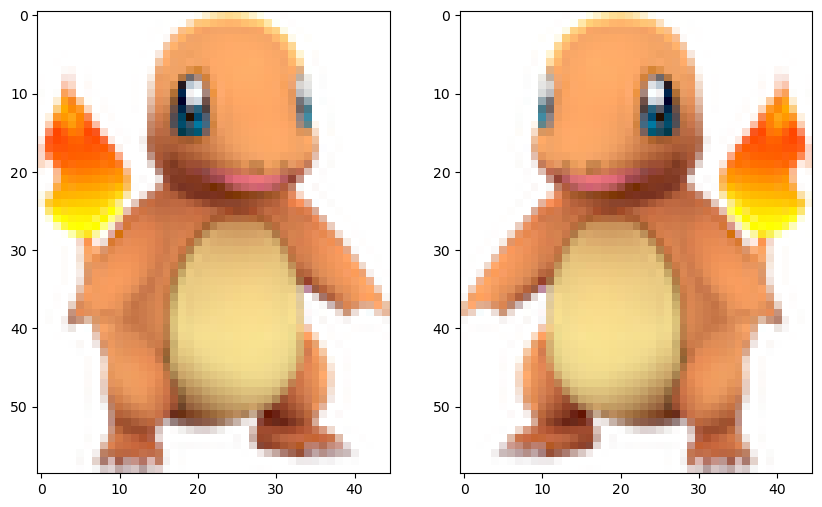

In [18]:
with Image.open('assets/images/charmander.png') as im:
    im_flipped = im.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
    
    ax = plt.subplot(1, 2, 1)
    ax.imshow(im_flipped)

    ax = plt.subplot(1, 2, 2)
    ax.imshow(im)

plt.show()

The only real change for this exercise is to update the LocalizationSequence class to include flipping the character 50% of the time.

In [19]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        with Image.open('assets/images/charmander.png') as im:
            self.charmander = im.copy()
        
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1.
        """
        return y / IMAGE_DIM
        
        
    def generate_charmander(self):
        """
        Generates a Charmander pokemon of a random size from 0.5 to
        1.5 the scale of the original one and flipped left to right
        50% of the time.
        """
        scale = random.uniform(0.5, 1.5)
        poke = self.charmander.resize(
            (int(self.charmander.width * scale), 
             int(self.charmander.height * scale)))

        if random.random() > 0.5:
            poke = poke.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
            
        return poke
        
        
    def generate_image(self):
        """
        Generates a random image with a Charmander inside it. 
        """
        img = np.zeros((IMAGE_DIM, IMAGE_DIM, 3))
        
        poke = self.generate_charmander()
        (char_width, char_height) = poke.size
        
        # create a numpy array from the image and strip out the
        # alpha channel
        poke_arr = np.array(poke)[:, :, 0:3]
        
        # normalize colours
        poke_arr = poke_arr / 255.
        
        char_top = random.randint(1, IMAGE_DIM - char_height)
        char_left = random.randint(1, IMAGE_DIM - char_width)
        
        img[char_top:char_top + char_height, 
            char_left:char_left + char_width] = poke_arr
        
        return img, self.preprocess_y_value(
            np.array([char_top, char_left, char_height, char_width])
        )
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return the batch size.
        """
        return self.batch_size
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        batch_y = np.empty([self.batch_size, 4], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
    


Let's test that out and see what it generates.

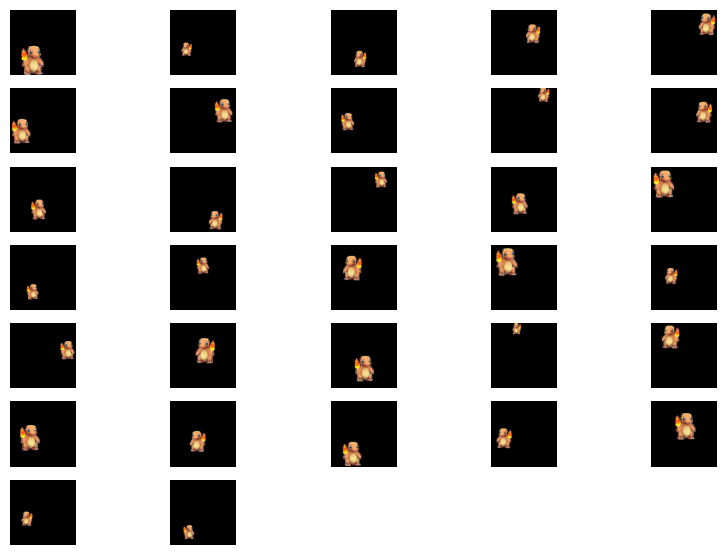

In [20]:
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.__len__())):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()


That all seems to be working fine, so the rest of the code stays the same as it was for the last exercise.

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [22]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(500, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation="sigmoid")(x)

# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

2022-10-30 08:17:39.448351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "Localization_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)

In [23]:
history = model.fit(seq, epochs=5)

Epoch 1/5
32/32 [==============================] - 141s 4s/step - loss: 0.5718 - accuracy: 0.8447
Epoch 2/5
32/32 [==============================] - 149s 5s/step - loss: 0.5511 - accuracy: 0.9463
Epoch 3/5
32/32 [==============================] - 151s 5s/step - loss: 0.5491 - accuracy: 0.9531
Epoch 4/5
32/32 [==============================] - 159s 5s/step - loss: 0.5528 - accuracy: 0.9668
Epoch 5/5
32/32 [==============================] - 164s 5s/step - loss: 0.5501 - accuracy: 0.9736


Plot the accuracy from the `model.fit()`.

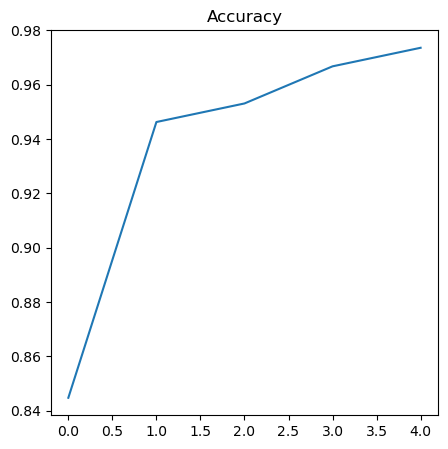

In [24]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [25]:
model.save('saved-models/localization-4.h5', overwrite=True)

The `to_pil_rect()` function takes the y outputs from the model and converts the values into the correct coordinates for the input.

In [26]:
def to_pil_rect(y):
    rv = y * IMAGE_DIM
    rv = np.clip(rv, 1, IMAGE_DIM - 1)
    [top, left, height, width] = rv
    height += top
    width += left
    rv[2] = height
    rv[3] = width
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [27]:
x, y = seq.__getitem__(0)
print(f'Generated data for predictions: {x.shape}')

Generated data for predictions: (32, 200, 200, 3)


Use the trained model to make some predictions from the new batch.

In [28]:
y_predicted = model.predict(x)

1/1 [==============================] - 5s 5s/step


Create the boxes for both the actual boxes and the predicted ones.

In [29]:
predicted_boxes = np.zeros((seq.batch_size, 4))
actual_boxes = np.zeros((seq.batch_size, 4))

for i, pred in enumerate(y_predicted):
    predicted_boxes[i] = to_pil_rect(pred)
    actual_boxes[i] = to_pil_rect(y[i])

Convert the numpy array into a PIL image so we can work with it as an image.

In [30]:
def add_bounding_boxes():
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)

        draw.rectangle(
            [actual_boxes[i][1], 
             actual_boxes[i][0], 
             actual_boxes[i][3], 
             actual_boxes[i][2]], outline='yellow')

        draw.rectangle(
            [predicted_boxes[i][1], 
             predicted_boxes[i][0], 
             predicted_boxes[i][3], 
             predicted_boxes[i][2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [31]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them as before.

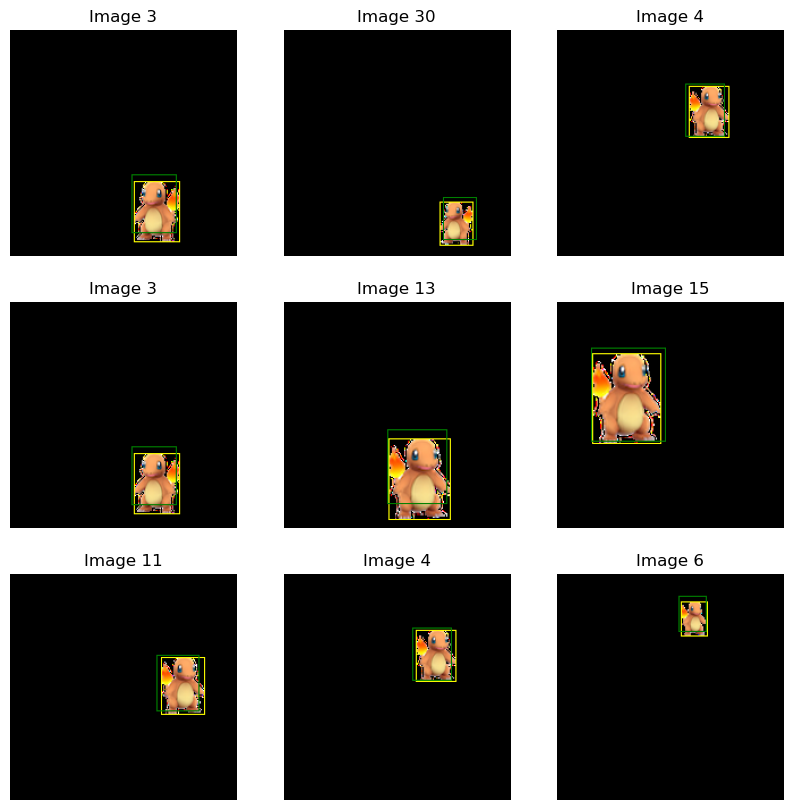

In [32]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'Image {im_idx}')

In the output above you can see the green boxes that are the results of the predictions and the yellow boxes that use the same maths to reverse the sigmoid function and validate that that maths is correct.